In [58]:
from pathlib import Path
import dask.array as da
import dask.dataframe as dd
import psutil
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

# Data location

In [59]:
lv2_path = Path('/net/pr2/projects/tutorial/2025-09-25-hpda/dataset/lv2/')
lv2_path.exists()

True

# Dask

In [61]:
from dask_jobqueue import SLURMCluster

cluster = SLURMCluster(cores=4,
                       memory="64GB",
                       account="tutorial",
                       walltime="00:30:00",
                       interface="ib0",
                       queue="tutorial")

/net/software/v1/software/dask/2025.5.1-gfbf-2025a/lib/python3.13/site-packages/distributed/node.py:187: UserWarning: Port 8787 is already in use.
Perhaps you already have a cluster running?
Hosting the HTTP server on port 38055 instead
  warnings.warn(


In [62]:
print(cluster.job_script())

#!/usr/bin/env bash

#SBATCH -J dask-worker
#SBATCH -p tutorial
#SBATCH -A tutorial
#SBATCH -n 1
#SBATCH --cpus-per-task=4
#SBATCH --mem=60G
#SBATCH -t 00:30:00

/net/software/trainings/2025/2025-09-25-hpda/venv-hpda/bin/python -m distributed.cli.dask_worker tcp://172.23.16.8:33907 --name dummy-name --nthreads 1 --memory-limit 14.90GiB --nworkers 4 --nanny --death-timeout 60 --interface ib0



In [63]:
cluster.scale(2)

In [64]:
#cluster.close()

In [65]:
from dask.distributed import Client
client = Client(cluster)
client

Connection method: Cluster object,Cluster type: dask_jobqueue.SLURMCluster
Dashboard: http://172.23.16.8:38055/status,
Dashboard: http://172.23.16.8:38055/status,Workers: 0
Total threads: 0,Total memory: 0 B
Comm: tcp://172.23.16.8:33907,Workers: 0
Dashboard: http://172.23.16.8:38055/status,Total threads: 0
Started: Just now,Total memory: 0 B


In [66]:
client

<Client: 'tcp://172.23.16.8:33907' processes=4 threads=4, memory=59.60 GiB>

In [67]:
lv2_path = Path('/net/pr2/projects/tutorial/2025-09-25-hpda/dataset/lv2/')
lv2_path.exists()

True

In [68]:
ddf = dd.read_parquet(
    lv2_path,
)

In [69]:
ddf.head()

,index,trc_file_no,segment_no,delta_t_sec,peak_rise_time_ns,peak_falling_time_ns,peak_cfd_ns,peak_area_mV_ns,peak_length_ns,peak_amplitude_mV,optimum_period_ns,mean_phase_shift_ns,spread_phase_shift_ns,micropulse_no,t_mid_ns,peak_offset_ns,sign,dataset,channel_no
0,0,0,0,0.0,0.386436,0.189930,827.425406,1.751539,0.148071,9.463067,38.081231,1.551495,0.537438,22.0,839.338587,-11.913181,negative,0p5nA,0
1,1,0,0,0.0,0.062531,0.440093,2645.148181,1.742134,0.124026,9.180918,38.081231,1.551495,0.537438,69.0,2629.156465,15.991716,negative,0p5nA,0
2,2,0,0,0.0,0.140212,0.061022,6722.365419,1.792294,0.142631,9.086869,38.081231,1.551495,0.537438,176.0,6703.848230,18.517189,negative,0p5nA,0
3,3,0,0,0.0,0.687940,0.070371,9100.102696,1.588519,0.104543,8.052322,38.081231,1.551495,0.537438,239.0,9102.965811,-2.863115,negative,0p5nA,0
4,4,0,0,0.0,0.128568,0.208718,22483.889270,1.651219,0.116299,8.679320,38.081231,1.551495,0.537438,590.0,22469.478049,14.411221,negative,0p5nA,0


In [70]:
ddf.npartitions

28

In [71]:
df = ddf.query('dataset=="0p5nA"')[['dataset', 'channel_no', 'trc_file_no', 'sign', 'peak_length_ns', 'peak_amplitude_mV']].repartition(npartitions=1000).persist()

In [72]:
df.peak_amplitude_mV.mean().compute()

np.float64(22.586671645890256)

In [73]:
hist_dask, edges_dask = da.histogram(df.query('channel_no==0 and trc_file_no==0 and sign=="negative" and peak_length_ns>0.4').peak_amplitude_mV, bins=200, range=(0, 200))

In [74]:
edges_dask

array([  0.,   1.,   2.,   3.,   4.,   5.,   6.,   7.,   8.,   9.,  10.,
        11.,  12.,  13.,  14.,  15.,  16.,  17.,  18.,  19.,  20.,  21.,
        22.,  23.,  24.,  25.,  26.,  27.,  28.,  29.,  30.,  31.,  32.,
        33.,  34.,  35.,  36.,  37.,  38.,  39.,  40.,  41.,  42.,  43.,
        44.,  45.,  46.,  47.,  48.,  49.,  50.,  51.,  52.,  53.,  54.,
        55.,  56.,  57.,  58.,  59.,  60.,  61.,  62.,  63.,  64.,  65.,
        66.,  67.,  68.,  69.,  70.,  71.,  72.,  73.,  74.,  75.,  76.,
        77.,  78.,  79.,  80.,  81.,  82.,  83.,  84.,  85.,  86.,  87.,
        88.,  89.,  90.,  91.,  92.,  93.,  94.,  95.,  96.,  97.,  98.,
        99., 100., 101., 102., 103., 104., 105., 106., 107., 108., 109.,
       110., 111., 112., 113., 114., 115., 116., 117., 118., 119., 120.,
       121., 122., 123., 124., 125., 126., 127., 128., 129., 130., 131.,
       132., 133., 134., 135., 136., 137., 138., 139., 140., 141., 142.,
       143., 144., 145., 146., 147., 148., 149., 15

In [75]:
hist_dask

dask.array<sum-aggregate, shape=(200,), dtype=int64, chunksize=(200,), chunktype=numpy.ndarray>

In [76]:
hist_dask_computed = hist_dask.compute()

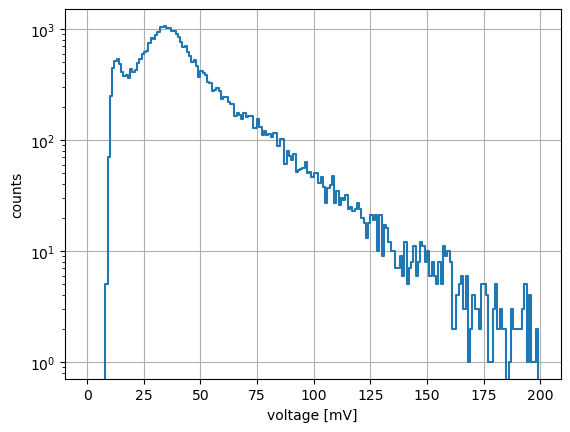

In [77]:
plt.plot(edges_dask[:-1], hist_dask_computed, drawstyle='steps-post')
plt.yscale('log')
plt.xlabel('voltage [mV]')
plt.ylabel('counts')
plt.grid()

# Some simple example

In [ ]:
# Generate some data
df = dd.demo.make_timeseries(
    start="1970-01-01",
    end="2022-12-31",
    dtypes={"x": float, "y": float, "a": float, "b": float, "c": float, "d": float},
    freq="1s",
    partition_freq="1ME",
    seed=1,
)



In [ ]:
df

In [ ]:


df.head()



In [ ]:
df.count().compute()

In [ ]:
df["x"].resample("1D").mean().compute().plot()
plt.xlabel("Date")
plt.ylabel("Mean of x")
plt.title("Daily Mean of x")
